## Теоретическая часть

**Задание 1**

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?

**Ответы:**

User-User рекомендации и Item-Item рекомендации основаны на произошедших взаимодействиях между пользователем и продуктом и, затем, выявлении похожих пользователей или продуктов (на основе k ближайших соседей) с целью создания рекомендательной системы. 


User-User рекомендации отличаются: 
* высокой дисперсией – они чувствительны к изменениям в данных: так как каждый пользователь взаимодействовал только с несколькими продуктами, то добавление новых пользователей может повлияет на результат;
* низким смещением – рекомендации осуществляются только по похожим пользователям, а значит рекомендации будут более «точными».    

В свою очередь, Item-Item рекомендации характеризуются:
* низкой дисперсией – они менее чувствительны к изменениям в данных (матрица более стабильна): так с каждым продуктом взаимодействовали много пользователей, то добавление новых данных, скорее всего, не сильно повлияет на результат;
* высоким смещением – рекомендации осуществляются исходя из взаимодействий всех пользователей, а значит рекомендации могут основываться на неверных предположениях и будут менее «точными».


Если функции item_item_rec(interaction_matrix) подать на вход транспонированную interaction_matrix, то будет считаться косинусное расстояние между пользователями, а не между продуктами, тогда это и будет user_user_rec. Если же мы хотим вычислить схожесть между пользователями на основе корреляции Пирсона или среднеквадратичной ошибки, то item_item_rec не подойдёт.

В ALS сегментируем пользователей по их предпочтениям некоторой группе продуктов, то улучшает способность рекомендовать менее популярные продукты, а в item-item рекомендациях находим похожие продукты на основе предпочтений всех пользователей.

**Задание 2**

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


**Ответы:**

* Частота взаимодействия с продуктом, например, в месяц или в неделю. Если пользователь обычно взаимодействует с продуктом раз в месяц, то через месяц можно его порекомендовать, если не было взаимодействия.
* Оценки продукта пользователями
* Размер скидки на товар

**Задание 3**

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


**Ответы:**

Веса должны быть численными. ALS квадратичная, значит она диференцируемая, и проблем с градиентным спуском не должно возникнуть.

## Практическая часть


NB: !pip install implicit

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

import warnings
warnings.filterwarnings('ignore')

In [12]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    #assert len(bought_list) > len(recommended_list)
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [74]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)]
    return res

NB:       
from google.colab import drive      
drive.mount('/content/drive')     
root = '/content/drive/My Drive/GB/RecSys/webinar_2/'

In [69]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [66]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [70]:
data_train_1 = data_train.copy()

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


**Число покупок**

In [71]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [72]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [77]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1.39 s


In [80]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
res_table = {}
res_table['quant_count'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
res_table['quant_count']

Wall time: 11.4 s


0.18530852105778375

**Число скидок**

In [82]:
data_train = data_train_1.copy()

In [83]:
disc_quant = data_train.groupby('item_id')['retail_disc'].count().reset_index()

top_disc_5000 = disc_quant.sort_values('retail_disc', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_disc_5000), 'item_id'] = 999999

In [84]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='retail_disc', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,397896,818980,818981,819063,819255,819304,819308,819330,819518,819594,...,15596279,15596488,15596515,15831255,15926712,15926775,15926844,15926886,15927403,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [86]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1.41 s


In [88]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
res_table['disc_count'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
res_table['disc_count']

Wall time: 12.4 s


0.18325171400587406

**Число купонов**

In [82]:
data_train = data_train_1.copy()

In [91]:
coupon_quant = data_train.groupby('item_id')['coupon_disc'].count().reset_index()

top_coupon_5000 = coupon_quant.sort_values('coupon_disc', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_coupon_5000), 'item_id'] = 999999

In [92]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='coupon_disc', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,397896,818980,818981,819063,819255,819304,819308,819330,819518,819594,...,15596279,15596488,15596515,15831255,15926712,15926775,15926844,15926886,15927403,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [94]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1.43 s


In [95]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
res_table['coupon_count'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
res_table['coupon_count']

Wall time: 12.6 s


0.18413320274240677

**trans_time**

In [98]:
data_train = data_train_1.copy()

In [99]:
trans_time = data_train.groupby('item_id')['trans_time'].sum().reset_index()

top_trans_5000 = trans_time.sort_values('trans_time', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_trans_5000), 'item_id'] = 999999

In [110]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='trans_time', # Можно пробоват ьдругие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,397896,818980,818981,819063,819255,819304,819308,819330,819518,819594,...,15596488,15596515,15717057,15831255,15926712,15926775,15926844,15926886,15927403,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1134.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1322.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [112]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1.48 s


In [113]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
res_table['trans_time'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
res_table['trans_time']

Wall time: 12 s


0.00695396669931439

In [115]:
res_table

{'quant_count': 0.18530852105778375,
 'disc_count': 0.18325171400587406,
 'coupon_count': 0.18413320274240677,
 'trans_time': 0.00695396669931439}

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [116]:
from sklearn.model_selection import GridSearchCV

In [118]:
data_train_1 = data_train.copy()

In [119]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [120]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,397896,818980,818981,819063,819255,819304,819308,819330,819518,819594,...,15596488,15596515,15717057,15831255,15926712,15926775,15926844,15926886,15927403,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [122]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1.47 s


In [123]:
%%time

results_factor = []
for factor in [50, 100, 200, 300]:
    model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    results_factor.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())

results_reg = []
for reg in [0.1, 0.05, 0.01, 0.005, 0.001]:
    model = AlternatingLeastSquares(factors=50, 
                                regularization=reg,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    results_reg.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 5min 20s


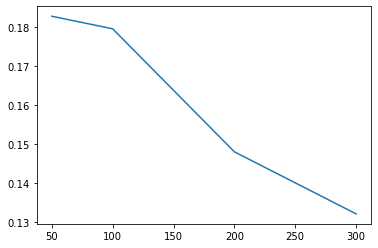

In [124]:
plt.plot([50, 100, 200, 300], results_factor)

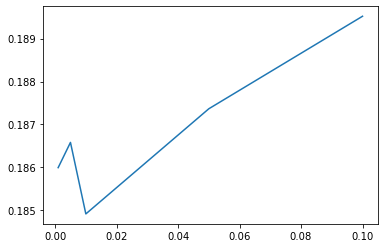

In [125]:
plt.plot([0.1, 0.05, 0.01, 0.005, 0.001], results_reg)

In [126]:
%%time

results_factor_2 = []
for factor in [10, 20, 30, 40, 50]:
    model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.1,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    results_factor_2.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 1min 8s


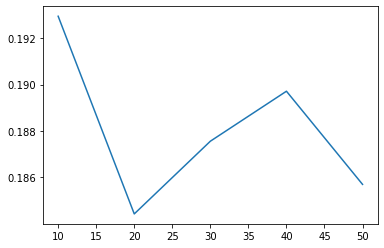

In [127]:
plt.plot([10, 20, 30, 40, 50], results_factor_2)

In [128]:
model = AlternatingLeastSquares(factors=10, 
                                regularization=0.1,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()


  0%|          | 0/15 [00:00<?, ?it/s]

0.1920666013712018